In [5]:
# =============
# CARGA DE LIBRERIAS

import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# =============
# INSTANCIACION DEL MODELO TRANSFORMER

# Configurar dispositivo para GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class Transformer(nn.Module):
    def __init__(self, num_points, d_model=128, nhead=8, num_layers=4, dim_feedforward=256):
        super(Transformer, self).__init__()
        self.embedding = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=d_model, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(d_model),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=d_model, out_channels=d_model, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(d_model),
            nn.MaxPool1d(kernel_size=2)
        )
        reduced_len = num_points // 16
        self.positional_encoding = PositionalEncoding(d_model, dropout=0.1, max_len=reduced_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=0.1, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc_layers = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1, 2)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = x.transpose(1, 2)
        x = self.pooling(x).squeeze(-1)
        out = self.fc_layers(x)
        return out

num_points = 5000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelTransformer = Transformer(num_points).to(device)

Usando dispositivo: cuda


Correlación lineal: -0.0884
Número de muestras evaluadas: 329989
Error medio: 0.627859


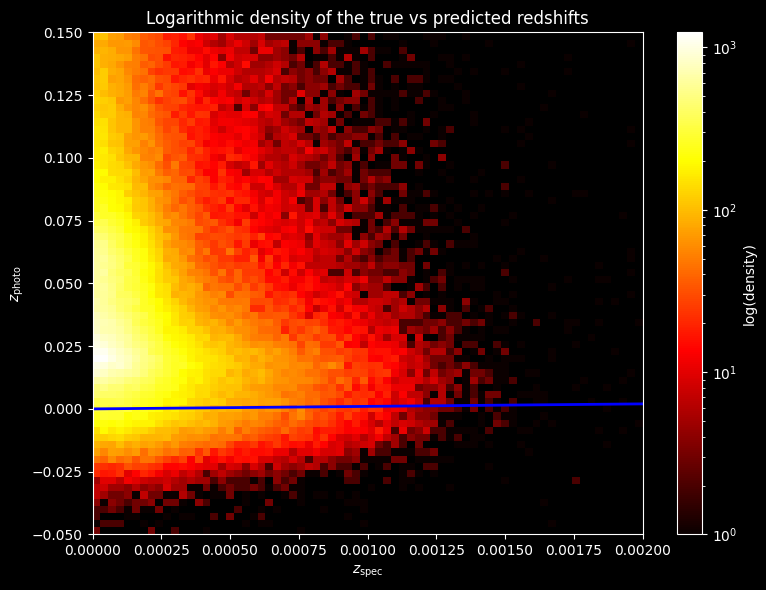

In [ ]:
# =============
# EVALUACION EN EL DATASET DE ESTRELLAS SIN RENORMALIZAR

num_points = 5000  # Numero de puntos en cada espectro
model_checkpoint = 'storage/modelTRA_1M.pth'  # Ruta del checkpoint del modelo

# Instanciar el modelo y cargar el checkpoint
modelTransformer = Transformer(num_points).to(device)
checkpoint = torch.load(model_checkpoint, map_location=device)
modelTransformer.load_state_dict(checkpoint['model_state_dict'])
modelTransformer.eval()

# Directorios y parametros
data_dir  = "data"
storage_dir = "storage"
batch_size = 32

# Definir la clase Dataset
class SpectraDataset(Dataset):
    def __init__(self, dataset_path):
        data = torch.load(dataset_path)
        self.flux = data["flux"]
        self.wavelength = data["wavelength"]
        self.redshift = data["redshift"]
    
    def __len__(self):
        return self.flux.shape[0]
    
    def __getitem__(self, idx):
        input_sample = torch.stack([self.flux[idx], self.wavelength[idx]], dim=0)  # [2, num_points]
        target = self.redshift[idx]
        return input_sample, target
    
    
data_dir = "data"
dataset_path = os.path.join(data_dir, "stars_dataset.pt")
dataset = SpectraDataset(dataset_path)
batch_size = 32
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

predicted = []
real = []

with torch.no_grad():
    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        preds = modelTransformer(x_batch).cpu().numpy()  # forma: (batch_size, 1)
        predicted.append(preds)
        real.append(y_batch.numpy())

# Concatenar los resultados de la primera mitad
ypredicted = np.concatenate(predicted, axis=0)
yreal = np.concatenate(real, axis=0)

ypredicted = ypredicted.squeeze()     # Ahora tiene forma (N,)
yreal      = yreal.squeeze()          # Ahora tiene forma (N,)

# Calcular la correlacion lineal
correlation = np.corrcoef(yreal, ypredicted)[0, 1]

print(f"Correlación lineal: {correlation:.4f}")
print(f"Número de muestras evaluadas: {len(yreal)}")
print(f"Error medio: {np.mean(np.abs(yreal - ypredicted)):.6f}")

# Mapa de calor de z_real frente a z_predicho estandar

plt.style.use('dark_background')

x_min, x_max = 0, 0.002
y_min, y_max = -0.05, 0.15

plt.figure(figsize=(8,6))

# Cálculo del histograma 2D con escala logaritmica
counts, xedges, yedges, im = plt.hist2d(
    yreal,                 # z_spec (redshift "real")
    ypredicted,            # z_photo (redshift "predicho")
    bins=70,
    range=[[x_min, x_max], [y_min, y_max]],
    cmap='hot',
    norm=colors.LogNorm()  # Densidad logaritmica
)

cbar = plt.colorbar(im, label='log(density)')

plt.plot([x_min, x_max], [x_min, x_max], color='blue', linewidth=2)
plt.xlabel(r'$z_{\mathrm{spec}}$')
plt.ylabel(r'$z_{\mathrm{photo}}$')
plt.title('Logarithmic density of the true vs predicted redshifts')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()

Se eliminaron 2 muestras con predicción NaN.
Muestras finales tras enmascarado: 18255
Correlación lineal: 0.8120
Error medio: 0.335313


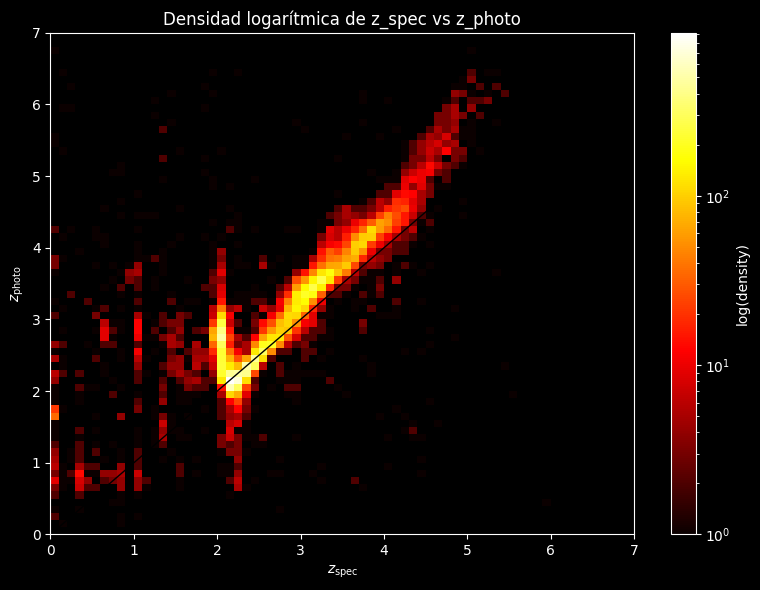

In [ ]:
# =============
# EVALUACION EN EL DATASET DE LA NASA SIN RENORMALIZAR

num_points = 5000  # Numero de puntos en cada espectro
model_checkpoint = 'storage/modelTRA_1M.pth'  # Ruta del checkpoint del modelo

# Instanciar el modelo y cargar el checkpoint
modelTransformer = Transformer(num_points).to(device)
checkpoint = torch.load(model_checkpoint, map_location=device)
modelTransformer.load_state_dict(checkpoint['model_state_dict'])
modelTransformer.eval()

# Directorios y parametros
data_dir  = "data"
storage_dir = "storage"
batch_size = 32

# Definir la clase Dataset
class SpectraDataset(Dataset):
    def __init__(self, dataset_path):
        data = torch.load(dataset_path)
        self.flux = data["flux"]
        self.wavelength = data["wavelength"]
        self.redshift = data["redshift"]
    
    def __len__(self):
        return self.flux.shape[0]
    
    def __getitem__(self, idx):
        input_sample = torch.stack([self.flux[idx], self.wavelength[idx]], dim=0)  # [2, num_points]
        target = self.redshift[idx]
        return input_sample, target
    
    
data_dir = "data"
dataset_path = os.path.join(data_dir, "NASA_dataset.pt")
dataset = SpectraDataset(dataset_path)
batch_size = 32
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

predicted = []
real = []

with torch.no_grad():
    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        preds = modelTransformer(x_batch).cpu().numpy()
        predicted.append(preds)
        real.append(y_batch.numpy())

ypredicted = np.concatenate(predicted, axis=0).squeeze()
yreal      = np.concatenate(real, axis=0).squeeze()

# Enmascarar NaNs
# Detectar NaNs en ypredicted
mask_nan = np.isnan(ypredicted)

# Invertir la mascara para quedarnos con valores validos
mask_valid = ~mask_nan

# Aplicar la mascara a ambos arrays
ypredicted_clean = ypredicted[mask_valid]
yreal_clean      = yreal[mask_valid]

# Reportar cuantos elementos se eliminaron
n_removed = mask_nan.sum()
print(f"Se eliminaron {n_removed} muestras con predicción NaN.")
print(f"Muestras finales tras enmascarado: {len(yreal_clean)}")

# Calcular la correlacion lineal con los datos limpios
correlation = np.corrcoef(yreal_clean, ypredicted_clean)[0, 1]
print(f"Correlación lineal: {correlation:.4f}")
print(f"Error medio: {np.mean(np.abs(yreal_clean - ypredicted_clean)):.6f}")

# Mapa de calor de z_real vs z_predicho
plt.style.use('dark_background')
x_min, x_max = 0, 7
y_min, y_max = 0, 7
plt.figure(figsize=(8,6))
counts, xedges, yedges, im = plt.hist2d(
    yreal_clean,
    ypredicted_clean,
    bins=70,
    range=[[x_min, x_max], [y_min, y_max]],
    cmap='hot',
    norm=colors.LogNorm()
)
cbar = plt.colorbar(im, label='log(density)')
plt.plot([x_min, x_max], [x_min, x_max], color='black', linewidth=1)
plt.xlabel(r'$z_{\mathrm{spec}}$')
plt.ylabel(r'$z_{\mathrm{photo}}$')
plt.title('Densidad logarítmica de z_spec vs z_photo')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()

Correlación lineal: -0.0554
Número de muestras evaluadas: 329989
Error medio: 0.579921


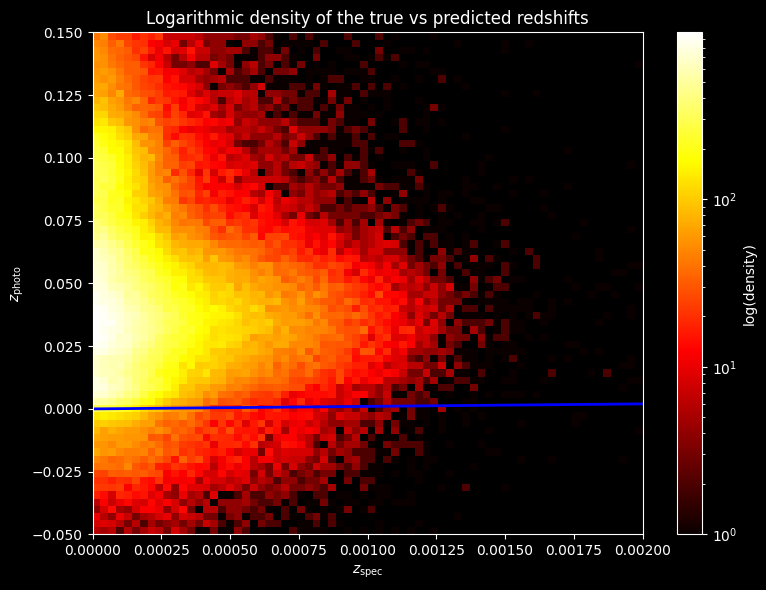

In [5]:
# =============
# EVALUACION EN EL DATASET DE ESTRELLAS RENORMALIZADO

num_points = 5000  # Numero de puntos en cada espectro
model_checkpoint = 'storage/modelTRA_1M_renorm.pth'  # Ruta del checkpoint del modelo

# Instanciar el modelo y cargar el checkpoint
modelTransformer = Transformer(num_points).to(device)
checkpoint = torch.load(model_checkpoint, map_location=device)
modelTransformer.load_state_dict(checkpoint['model_state_dict'])
modelTransformer.eval()

# Directorios y parametros
data_dir  = "data"
storage_dir = "storage"
batch_size = 32

# Definir la clase Dataset
class SpectraDataset(Dataset):
    def __init__(self, dataset_path):
        data = torch.load(dataset_path)
        self.flux = data["flux"]
        self.wavelength = data["wavelength"]
        self.redshift = data["redshift"]
    
    def __len__(self):
        return self.flux.shape[0]
    
    def __getitem__(self, idx):
        input_sample = torch.stack([self.flux[idx], self.wavelength[idx]], dim=0)  # [2, num_points]
        target = self.redshift[idx]
        return input_sample, target
    
    
data_dir = "data"
dataset_path = os.path.join(data_dir, "stars_dataset_renorm.pt")
dataset = SpectraDataset(dataset_path)
batch_size = 32
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

predicted = []
real = []

with torch.no_grad():
    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        preds = modelTransformer(x_batch).cpu().numpy()  # forma: (batch_size, 1)
        predicted.append(preds)
        real.append(y_batch.numpy())

# Concatenar los resultados de la primera mitad
ypredicted = np.concatenate(predicted, axis=0)
yreal = np.concatenate(real, axis=0)

ypredicted = ypredicted.squeeze()     # Ahora tiene forma (N,)
yreal      = yreal.squeeze()          # Ahora tiene forma (N,)

# Calcular la correlacion lineal
correlation = np.corrcoef(yreal, ypredicted)[0, 1]

print(f"Correlación lineal: {correlation:.4f}")
print(f"Número de muestras evaluadas: {len(yreal)}")
print(f"Error medio: {np.mean(np.abs(yreal - ypredicted)):.6f}")

# Mapa de calor de z_real frente a z_predicho estandar

plt.style.use('dark_background')

x_min, x_max = 0, 0.002
y_min, y_max = -0.05, 0.15

plt.figure(figsize=(8,6))

# Calculo del histograma 2D con escala logaritmica
counts, xedges, yedges, im = plt.hist2d(
    yreal,                 # z_spec (redshift "real")
    ypredicted,            # z_photo (redshift "predicho")
    bins=70,
    range=[[x_min, x_max], [y_min, y_max]],
    cmap='hot',
    norm=colors.LogNorm()  # Densidad logaritmica
)

cbar = plt.colorbar(im, label='log(density)')

plt.plot([x_min, x_max], [x_min, x_max], color='blue', linewidth=2)
plt.xlabel(r'$z_{\mathrm{spec}}$')
plt.ylabel(r'$z_{\mathrm{photo}}$')
plt.title('Logarithmic density of the true vs predicted redshifts')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()

Se eliminaron 2 muestras con predicción NaN.
Muestras finales tras enmascarado: 18255
Correlación lineal: 0.7200
Error medio: 0.483495


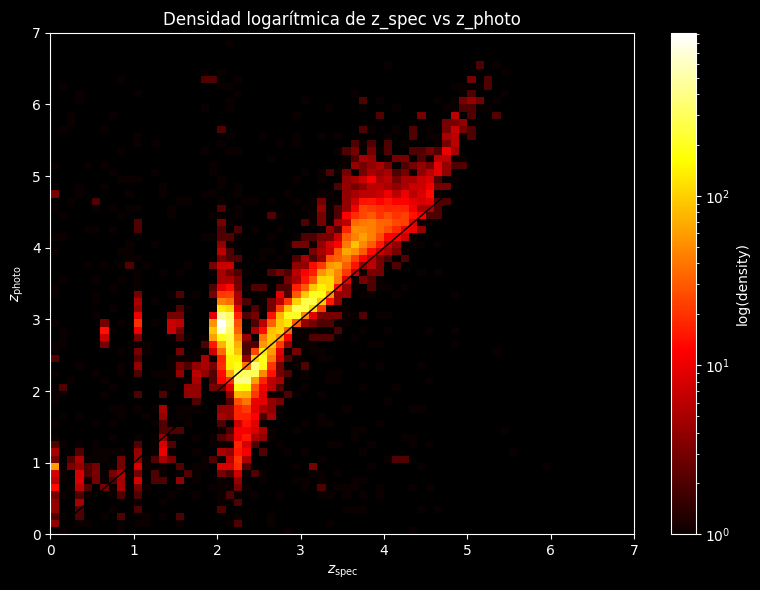

In [6]:
# =============
# EVALUACION EN EL DATASET DE LA NASA RENORMALIZADO

num_points = 5000  # Numero de puntos en cada espectro
model_checkpoint = 'storage/modelTRA_1M_renorm.pth'  # Ruta del checkpoint del modelo

# Instanciar el modelo y cargar el checkpoint
modelTransformer = Transformer(num_points).to(device)
checkpoint = torch.load(model_checkpoint, map_location=device)
modelTransformer.load_state_dict(checkpoint['model_state_dict'])
modelTransformer.eval()

# Directorios y parametros
data_dir  = "data"
storage_dir = "storage"
batch_size = 32

# Definir la clase Dataset
class SpectraDataset(Dataset):
    def __init__(self, dataset_path):
        data = torch.load(dataset_path)
        self.flux = data["flux"]
        self.wavelength = data["wavelength"]
        self.redshift = data["redshift"]
    
    def __len__(self):
        return self.flux.shape[0]
    
    def __getitem__(self, idx):
        input_sample = torch.stack([self.flux[idx], self.wavelength[idx]], dim=0)  # [2, num_points]
        target = self.redshift[idx]
        return input_sample, target

data_dir = "data"
dataset_path = os.path.join(data_dir, "NASA_dataset_renorm.pt")
dataset = SpectraDataset(dataset_path)
batch_size = 32
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

predicted = []
real = []

with torch.no_grad():
    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        preds = modelTransformer(x_batch).cpu().numpy()
        predicted.append(preds)
        real.append(y_batch.numpy())

ypredicted = np.concatenate(predicted, axis=0).squeeze()
yreal      = np.concatenate(real, axis=0).squeeze()

# Enmascarar NaNs
# Detectar NaNs en ypredicted
mask_nan = np.isnan(ypredicted)

# Invertir la mascara para quedarnos con valores validos
mask_valid = ~mask_nan

# Aplicar la mascara a ambos arrays
ypredicted_clean = ypredicted[mask_valid]
yreal_clean      = yreal[mask_valid]

# Reportar cuantos elementos se eliminaron
n_removed = mask_nan.sum()
print(f"Se eliminaron {n_removed} muestras con predicción NaN.")
print(f"Muestras finales tras enmascarado: {len(yreal_clean)}")

# Calcular la correlacion lineal con los datos limpios
correlation = np.corrcoef(yreal_clean, ypredicted_clean)[0, 1]
print(f"Correlación lineal: {correlation:.4f}")
print(f"Error medio: {np.mean(np.abs(yreal_clean - ypredicted_clean)):.6f}")

# Mapa de calor de z_real vs z_predicho
plt.style.use('dark_background')
x_min, x_max = 0, 7
y_min, y_max = 0, 7
plt.figure(figsize=(8,6))
counts, xedges, yedges, im = plt.hist2d(
    yreal_clean,
    ypredicted_clean,
    bins=70,
    range=[[x_min, x_max], [y_min, y_max]],
    cmap='hot',
    norm=colors.LogNorm()
)
cbar = plt.colorbar(im, label='log(density)')
plt.plot([x_min, x_max], [x_min, x_max], color='black', linewidth=1)
plt.xlabel(r'$z_{\mathrm{spec}}$')
plt.ylabel(r'$z_{\mathrm{photo}}$')
plt.title('Densidad logarítmica de z_spec vs z_photo')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()

In [7]:
# =============
# COMPARACION ENTRE EL DATASET DE 600K Y 1M
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

predicted1_MLP600k = np.load("storage/predicted1_MLP600k.npy")
predicted2_MLP600k = np.load("storage/predicted2_MLP600k.npy")
real1_MLP600k      = np.load("storage/real1_MLP600k.npy")
real2_MLP600k      = np.load("storage/real2_MLP600k.npy")
ypredicted_MLP600k = np.concatenate([predicted1_MLP600k, predicted2_MLP600k], axis=0)
yreal_MLP600k      = np.concatenate([real1_MLP600k, real2_MLP600k], axis=0)

predicted1_CNN600k_0 = np.load("storage/predicted1_CNN600k_0.npy")
predicted2_CNN600k_0 = np.load("storage/predicted2_CNN600k_0.npy")
real1_CNN600k_0      = np.load("storage/real1_CNN600k_0.npy")
real2_CNN600k_0      = np.load("storage/real2_CNN600k_0.npy")
ypredicted_CNN600k_0 = np.concatenate([predicted1_CNN600k_0, predicted2_CNN600k_0], axis=0)
yreal_CNN600k_0      = np.concatenate([real1_CNN600k_0, real2_CNN600k_0], axis=0)

predicted1_CNN600k_1 = np.load("storage/predicted1_CNN600k_1.npy")
predicted2_CNN600k_1 = np.load("storage/predicted2_CNN600k_1.npy")
real1_CNN600k_1      = np.load("storage/real1_CNN600k_1.npy")
real2_CNN600k_1      = np.load("storage/real2_CNN600k_1.npy")
ypredicted_CNN600k_1 = np.concatenate([predicted1_CNN600k_1, predicted2_CNN600k_1], axis=0)
yreal_CNN600k_1      = np.concatenate([real1_CNN600k_1, real2_CNN600k_1], axis=0)

predicted1_CNN600k_2 = np.load("storage/predicted1_CNN600k_2.npy")
predicted2_CNN600k_2 = np.load("storage/predicted2_CNN600k_2.npy")
real1_CNN600k_2      = np.load("storage/real1_CNN600k_2.npy")
real2_CNN600k_2      = np.load("storage/real2_CNN600k_2.npy")
ypredicted_CNN600k_2 = np.concatenate([predicted1_CNN600k_2, predicted2_CNN600k_2], axis=0)
yreal_CNN600k_2      = np.concatenate([real1_CNN600k_2, real2_CNN600k_2], axis=0)

predicted1_CNN600k_3 = np.load("storage/predicted1_CNN600k_3.npy")
predicted2_CNN600k_3 = np.load("storage/predicted2_CNN600k_3.npy")
real1_CNN600k_3      = np.load("storage/real1_CNN600k_3.npy")
real2_CNN600k_3      = np.load("storage/real2_CNN600k_3.npy")
ypredicted_CNN600k_3 = np.concatenate([predicted1_CNN600k_3, predicted2_CNN600k_3], axis=0)
yreal_CNN600k_3      = np.concatenate([real1_CNN600k_3, real2_CNN600k_3], axis=0)

# predicted1_CNN600k_4 = np.load("storage/predicted1_CNN600k_4.npy")
# predicted2_CNN600k_4 = np.load("storage/predicted2_CNN600k_4.npy")
# real1_CNN600k_4      = np.load("storage/real1_CNN600k_4.npy")
# real2_CNN600k_4      = np.load("storage/real2_CNN600k_4.npy")
# ypredicted_CNN600k_4 = np.concatenate([predicted1_CNN600k_4, predicted2_CNN600k_4], axis=0)
# yreal_CNN600k_4      = np.concatenate([real1_CNN600k_4, real2_CNN600k_4], axis=0)

predicted1_TRA600k = np.load("storage/predicted1_TRA600k.npy")
predicted2_TRA600k = np.load("storage/predicted2_TRA600k.npy")
real1_TRA600k      = np.load("storage/real1_TRA600k.npy")
real2_TRA600k      = np.load("storage/real2_TRA600k.npy")
ypredicted_TRA600k = np.concatenate([predicted1_TRA600k, predicted2_TRA600k], axis=0)
yreal_TRA600k      = np.concatenate([real1_TRA600k, real2_TRA600k], axis=0)


predicted1_MLP1M = np.load("storage/predicted1_MLP1M.npy")
predicted2_MLP1M = np.load("storage/predicted2_MLP1M.npy")
real1_MLP1M      = np.load("storage/real1_MLP1M.npy")
real2_MLP1M      = np.load("storage/real2_MLP1M.npy")
ypredicted_MLP1M = np.concatenate([predicted1_MLP1M, predicted2_MLP1M], axis=0)
yreal_MLP1M      = np.concatenate([real1_MLP1M, real2_MLP1M], axis=0)

predicted1_CNN1M_0 = np.load("storage/predicted1_CNN1M_0.npy")
predicted2_CNN1M_0 = np.load("storage/predicted2_CNN1M_0.npy")
real1_CNN1M_0      = np.load("storage/real1_CNN1M_0.npy")
real2_CNN1M_0      = np.load("storage/real2_CNN1M_0.npy")
ypredicted_CNN1M_0 = np.concatenate([predicted1_CNN1M_0, predicted2_CNN1M_0], axis=0)
yreal_CNN1M_0      = np.concatenate([real1_CNN1M_0, real2_CNN1M_0], axis=0)

predicted1_CNN1M_1 = np.load("storage/predicted1_CNN1M_1.npy")
predicted2_CNN1M_1 = np.load("storage/predicted2_CNN1M_1.npy")
real1_CNN1M_1      = np.load("storage/real1_CNN1M_1.npy")
real2_CNN1M_1      = np.load("storage/real2_CNN1M_1.npy")
ypredicted_CNN1M_1 = np.concatenate([predicted1_CNN1M_1, predicted2_CNN1M_1], axis=0)
yreal_CNN1M_1      = np.concatenate([real1_CNN1M_1, real2_CNN1M_1], axis=0)

predicted1_CNN1M_2 = np.load("storage/predicted1_CNN1M_2.npy")
predicted2_CNN1M_2 = np.load("storage/predicted2_CNN1M_2.npy")
real1_CNN1M_2      = np.load("storage/real1_CNN1M_2.npy")
real2_CNN1M_2      = np.load("storage/real2_CNN1M_2.npy")
ypredicted_CNN1M_2 = np.concatenate([predicted1_CNN1M_2, predicted2_CNN1M_2], axis=0)
yreal_CNN1M_2      = np.concatenate([real1_CNN1M_2, real2_CNN1M_2], axis=0)

predicted1_CNN1M_3 = np.load("storage/predicted1_CNN1M_3.npy")
predicted2_CNN1M_3 = np.load("storage/predicted2_CNN1M_3.npy")
real1_CNN1M_3      = np.load("storage/real1_CNN1M_3.npy")
real2_CNN1M_3      = np.load("storage/real2_CNN1M_3.npy")
ypredicted_CNN1M_3 = np.concatenate([predicted1_CNN1M_3, predicted2_CNN1M_3], axis=0)
yreal_CNN1M_3      = np.concatenate([real1_CNN1M_3, real2_CNN1M_3], axis=0)

# predicted1_CNN1M_4 = np.load("storage/predicted1_CNN1M_4.npy")
# predicted2_CNN1M_4 = np.load("storage/predicted2_CNN1M_4.npy")
# real1_CNN1M_4      = np.load("storage/real1_CNN1M_4.npy")
# real2_CNN1M_4      = np.load("storage/real2_CNN1M_4.npy")
# ypredicted_CNN1M_4 = np.concatenate([predicted1_CNN1M_4, predicted2_CNN1M_4], axis=0)
# yreal_CNN1M_4      = np.concatenate([real1_CNN1M_4, real2_CNN1M_4], axis=0)

predicted1_TRA1M_30_epochs = np.load("storage/predicted1_TRA1M (30 epochs).npy")
predicted2_TRA1M_30_epochs = np.load("storage/predicted2_TRA1M (30 epochs).npy")
real1_TRA1M_30_epochs      = np.load("storage/real1_TRA1M (30 epochs).npy")
real2_TRA1M_30_epochs      = np.load("storage/real2_TRA1M (30 epochs).npy")
ypredicted_TRA1M_30_epochs = np.concatenate([predicted1_TRA1M_30_epochs, predicted2_TRA1M_30_epochs], axis=0)
yreal_TRA1M_30_epochs      = np.concatenate([real1_TRA1M_30_epochs, real2_TRA1M_30_epochs], axis=0)


ypredicted_600k_all = np.concatenate([
    ypredicted_MLP600k,
    ypredicted_CNN600k_0,
    ypredicted_CNN600k_1,
    ypredicted_CNN600k_2,
    ypredicted_CNN600k_3,
    ypredicted_TRA600k
], axis=0).squeeze()

yreal_600k_all = np.concatenate([
    yreal_MLP600k,
    yreal_CNN600k_0,
    yreal_CNN600k_1,
    yreal_CNN600k_2,
    yreal_CNN600k_3,
    yreal_TRA600k
], axis=0).squeeze()

ypredicted_1m_all = np.concatenate([
    ypredicted_MLP1M,
    ypredicted_CNN1M_0,
    ypredicted_CNN1M_1,
    ypredicted_CNN1M_2,
    ypredicted_CNN1M_3,
    ypredicted_TRA1M_30_epochs,
], axis=0).squeeze()

yreal_1m_all = np.concatenate([
    yreal_MLP1M,
    yreal_CNN1M_0,
    yreal_CNN1M_1,
    yreal_CNN1M_2,
    yreal_CNN1M_3,
    yreal_TRA1M_30_epochs,
], axis=0).squeeze()

Correlación lineal: 0.0071
Error medio: 0.109724
Número de muestras evaluadas: 20237340


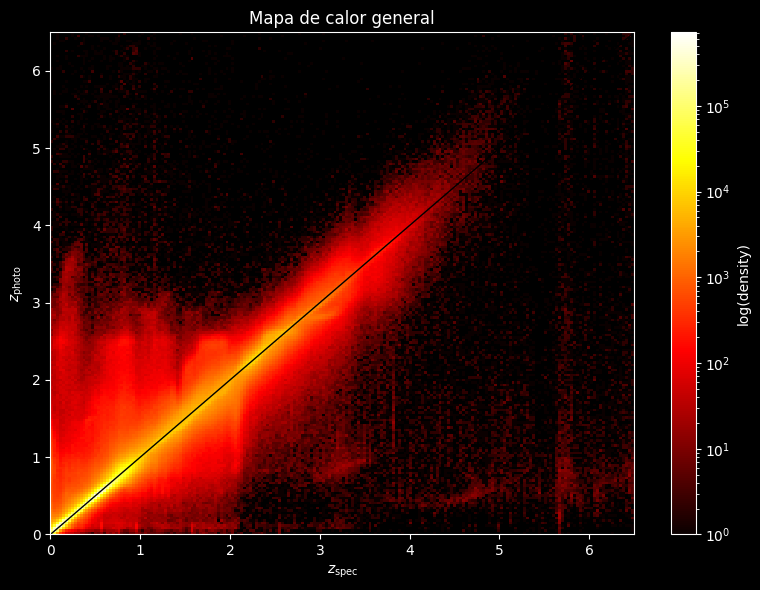

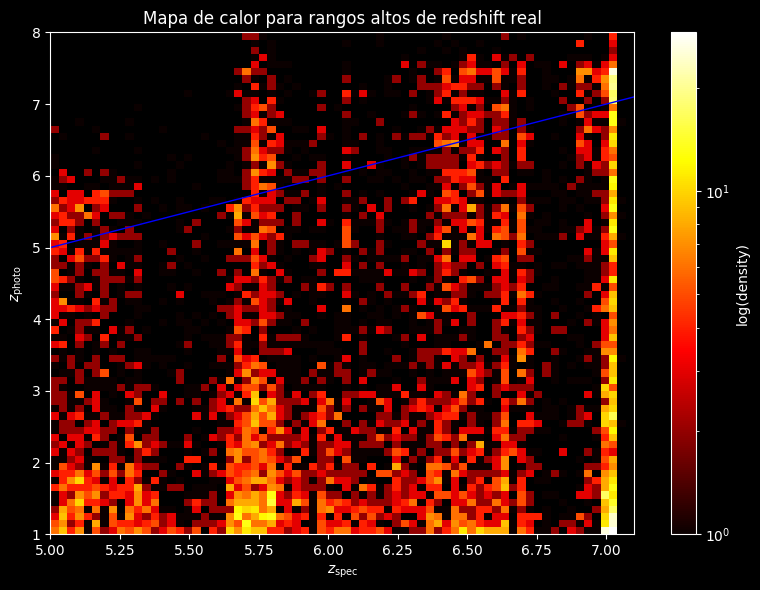

Error medio absoluto (alta z): 3.691679


In [8]:
# 600k

# Calcular la correlacion lineal
correlation_600k = np.corrcoef(ypredicted_600k_all, yreal_600k_all)[0, 1]

print(f"Correlación lineal: {correlation_600k:.4f}")
print(f"Error medio: {np.mean(np.abs(yreal_600k_all - ypredicted_600k_all)):.6f}")
print(f"Número de muestras evaluadas: {len(yreal_600k_all)}")

# Mapa de calor de z_real frente a z_predicho estandar

plt.style.use('dark_background')

x_min, x_max = 0, 6.5
y_min, y_max = 0, 6.5

plt.figure(figsize=(8,6))

# Calculo del histograma 2D con escala logaritmica
counts, xedges, yedges, im = plt.hist2d(
    yreal_600k_all,                 # z_spec (redshift "real")
    ypredicted_600k_all,            # z_photo (redshift "predicho")
    bins=200,
    range=[[x_min, x_max], [y_min, y_max]],
    cmap='hot',
    norm=colors.LogNorm()  # Densidad logaritmica
)

cbar = plt.colorbar(im, label='log(density)')

plt.plot([x_min, x_max], [x_min, x_max], color='black', linewidth=1)
plt.xlabel(r'$z_{\mathrm{spec}}$')
plt.ylabel(r'$z_{\mathrm{photo}}$')
plt.title('Mapa de calor general')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()

# Mapa de calor de z_real frente a z_predicho para comprobar rangos altos

plt.style.use('dark_background')

x_min, x_max = 5, 7.1
y_min, y_max = 1, 8

plt.figure(figsize=(8,6))

# Calculo del histograma 2D con escala logaritmica
counts, xedges, yedges, im = plt.hist2d(
    yreal_600k_all,                 # z_spec (redshift "real")
    ypredicted_600k_all,            # z_photo (redshift "predicho")
    bins=70,
    range=[[x_min, x_max], [y_min, y_max]],
    cmap='hot',
    norm=colors.LogNorm()  # Densidad logaritmica
)

cbar = plt.colorbar(im, label='log(density)')

plt.plot([x_min, x_max], [x_min, x_max], color='blue', linewidth=1)
plt.xlabel(r'$z_{\mathrm{spec}}$')
plt.ylabel(r'$z_{\mathrm{photo}}$')
plt.title('Mapa de calor para rangos altos de redshift real')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()


mask_high_values = yreal_600k_all >= 5
yreal_high = yreal_600k_all[mask_high_values]
ypred_high = ypredicted_600k_all[mask_high_values]
mae_high = np.mean(np.abs(yreal_high - ypred_high))
print(f"Error medio absoluto (alta z): {mae_high:.6f}")

Correlación lineal: 0.0096
Error medio: 0.104043
Número de muestras evaluadas: 20237340


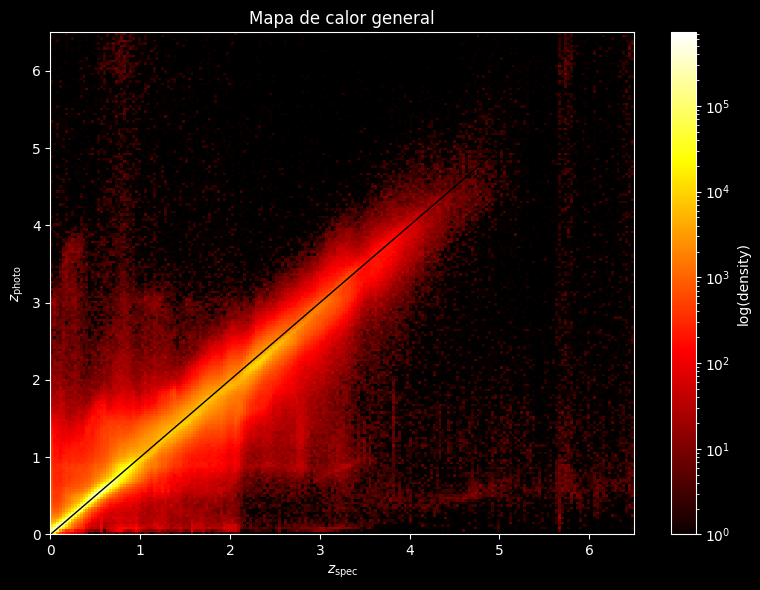

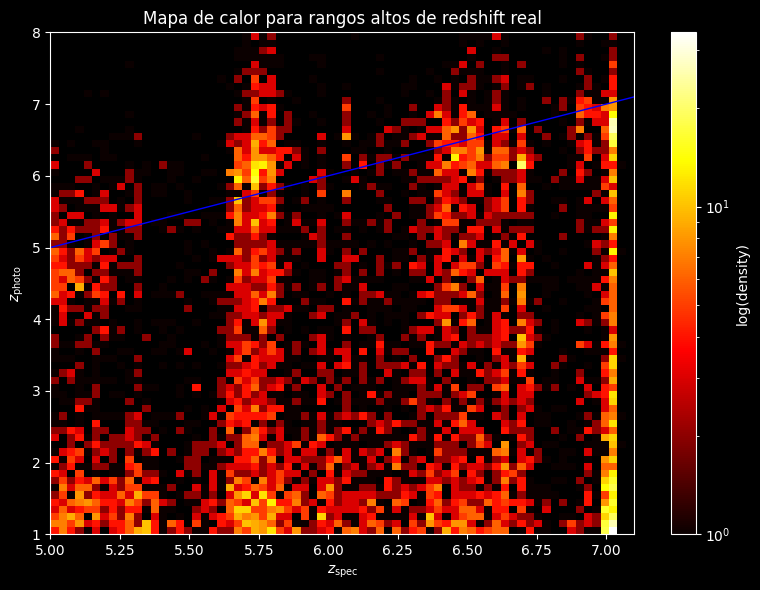

In [9]:
# 1M

# Calcular la correlacion lineal
correlation_1m = np.corrcoef(ypredicted_1m_all, yreal_1m_all)[0, 1]

print(f"Correlación lineal: {correlation_1m:.4f}")
print(f"Error medio: {np.mean(np.abs(yreal_1m_all - ypredicted_1m_all)):.6f}")
print(f"Número de muestras evaluadas: {len(yreal_1m_all)}")

# Mapa de calor de z_real frente a z_predicho estandar

plt.style.use('dark_background')

x_min, x_max = 0, 6.5
y_min, y_max = 0, 6.5

plt.figure(figsize=(8,6))

# Calculo del histograma 2D con escala logaritmica
counts, xedges, yedges, im = plt.hist2d(
    yreal_1m_all,                 # z_spec (redshift "real")
    ypredicted_1m_all,            # z_photo (redshift "predicho")
    bins=200,
    range=[[x_min, x_max], [y_min, y_max]],
    cmap='hot',
    norm=colors.LogNorm()  # Densidad logaritmica
)

cbar = plt.colorbar(im, label='log(density)')

plt.plot([x_min, x_max], [x_min, x_max], color='black', linewidth=1)
plt.xlabel(r'$z_{\mathrm{spec}}$')
plt.ylabel(r'$z_{\mathrm{photo}}$')
plt.title('Mapa de calor general')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()


# Mapa de calor de z_real frente a z_predicho para comprobar rangos altos

plt.style.use('dark_background')

x_min, x_max = 5, 7.1
y_min, y_max = 1, 8

plt.figure(figsize=(8,6))

# Calculo del histograma 2D con escala logaritmica
counts, xedges, yedges, im = plt.hist2d(
    yreal_1m_all,                 # z_spec (redshift "real")
    ypredicted_1m_all,            # z_photo (redshift "predicho")
    bins=70,
    range=[[x_min, x_max], [y_min, y_max]],
    cmap='hot',
    norm=colors.LogNorm()  # Densidad logaritmica
)

cbar = plt.colorbar(im, label='log(density)')

plt.plot([x_min, x_max], [x_min, x_max], color='blue', linewidth=1)
plt.xlabel(r'$z_{\mathrm{spec}}$')
plt.ylabel(r'$z_{\mathrm{photo}}$')
plt.title('Mapa de calor para rangos altos de redshift real')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()

Correlación lineal: 0.9751
Error medio: 0.029846
Número de muestras evaluadas: 3372890


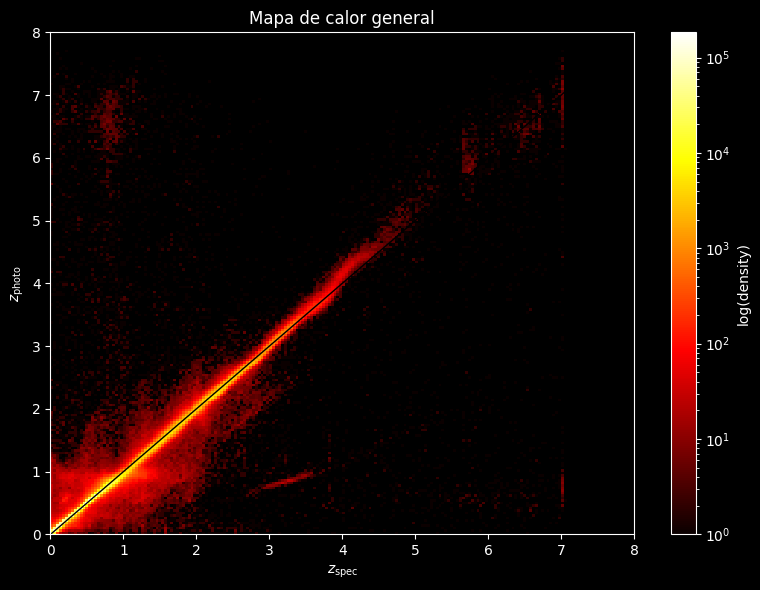

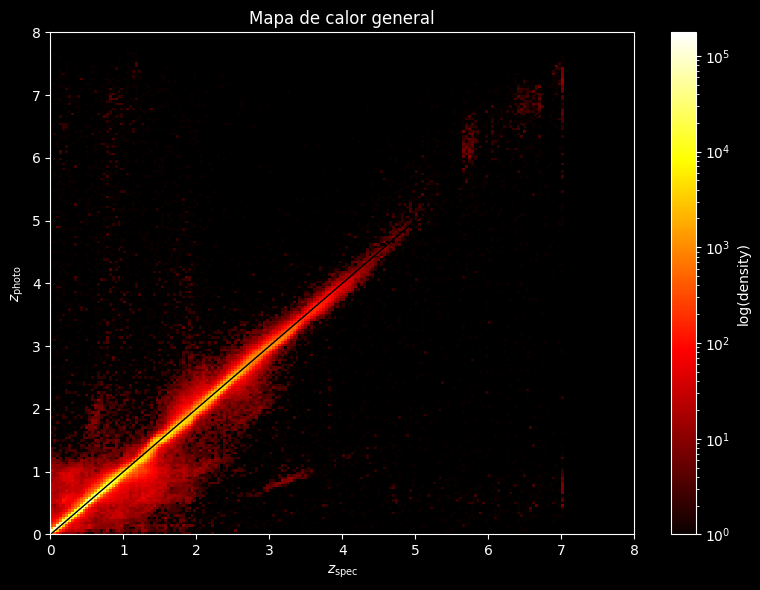

Error medio absoluto (alta z): 1.800111
Número de elementos predichos como negativos: 665


In [10]:
# =============
# COMPARACION ENTRE LOS MODELOS RENORMALIZADO Y NO RENORMALIZADO

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

predicted1_TRA1M = np.load("storage/predicted1_TRA1M.npy")
predicted2_TRA1M = np.load("storage/predicted2_TRA1M.npy")
real1_TRA1M      = np.load("storage/real1_TRA1M.npy")
real2_TRA1M      = np.load("storage/real2_TRA1M.npy")
ypredicted_TRA1M = np.concatenate([predicted1_TRA1M, predicted2_TRA1M], axis=0).squeeze()
yreal_TRA1M      = np.concatenate([real1_TRA1M, real2_TRA1M], axis=0).squeeze()

predicted1_TRA1M_renorm = np.load("storage/predicted1_TRA1M_renorm.npy")
predicted2_TRA1M_renorm = np.load("storage/predicted2_TRA1M_renorm.npy")
real1_TRA1M_renorm      = np.load("storage/real1_TRA1M_renorm.npy")
real2_TRA1M_renorm      = np.load("storage/real2_TRA1M_renorm.npy")
ypredicted_TRA1M_renorm = np.concatenate([predicted1_TRA1M_renorm, predicted2_TRA1M_renorm], axis=0).squeeze()
yreal_TRA1M_renorm      = np.concatenate([real1_TRA1M_renorm, real2_TRA1M_renorm], axis=0).squeeze()


# Calcular la correlacion lineal
correlation_1m = np.corrcoef(yreal_TRA1M_renorm, ypredicted_TRA1M_renorm)[0, 1]

print(f"Correlación lineal: {correlation_1m:.4f}")
print(f"Error medio: {np.mean(np.abs(yreal_TRA1M_renorm - ypredicted_TRA1M_renorm)):.6f}")
print(f"Número de muestras evaluadas: {len(yreal_TRA1M_renorm)}")








# Mapa de calor de z_real frente a z_predicho estandar

plt.style.use('dark_background')

x_min, x_max = 0, 8
y_min, y_max = 0, 8

plt.figure(figsize=(8,6))

# Calculo del histograma 2D con escala logaritmica
counts, xedges, yedges, im = plt.hist2d(
    yreal_TRA1M,                 # z_spec (redshift "real")
    ypredicted_TRA1M,            # z_photo (redshift "predicho")
    bins=200,
    range=[[x_min, x_max], [y_min, y_max]],
    cmap='hot',
    norm=colors.LogNorm()  # Densidad logaritmica
)

cbar = plt.colorbar(im, label='log(density)')

plt.plot([x_min, x_max], [x_min, x_max], color='black', linewidth=1)
plt.xlabel(r'$z_{\mathrm{spec}}$')
plt.ylabel(r'$z_{\mathrm{photo}}$')
plt.title('Mapa de calor general')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()






# Mapa de calor de z_real frente a z_predicho estandar

plt.style.use('dark_background')

x_min, x_max = 0, 8
y_min, y_max = 0, 8

plt.figure(figsize=(8,6))

# Calculo del histograma 2D con escala logaritmica
counts, xedges, yedges, im = plt.hist2d(
    yreal_TRA1M_renorm,                 # z_spec (redshift "real")
    ypredicted_TRA1M_renorm,            # z_photo (redshift "predicho")
    bins=200,
    range=[[x_min, x_max], [y_min, y_max]],
    cmap='hot',
    norm=colors.LogNorm()  # Densidad logaritmica
)

cbar = plt.colorbar(im, label='log(density)')

plt.plot([x_min, x_max], [x_min, x_max], color='black', linewidth=1)
plt.xlabel(r'$z_{\mathrm{spec}}$')
plt.ylabel(r'$z_{\mathrm{photo}}$')
plt.title('Mapa de calor general')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()

mask_high_values = yreal_TRA1M_renorm >= 5
yreal_high = yreal_TRA1M_renorm[mask_high_values]
ypred_high = ypredicted_TRA1M_renorm[mask_high_values]
mae_high = np.mean(np.abs(yreal_high - ypred_high))
print(f"Error medio absoluto (alta z): {mae_high:.6f}")

mask = ypredicted_TRA1M_renorm < 0
print(f"Número de elementos predichos como negativos: {np.sum(mask)}")